In [0]:
import numpy as np
import cv2
import os
import json
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

## Processing Training Data

In [0]:
images = os.listdir('train_images/')

In [0]:
### Images with label id
train_data = json.load(open('fgvc4_iMat.train.data.json', 'r'))

### Label map
task_data = json.load(open('fgvc4_iMat.task_map.json', 'r'))

In [0]:
### Load images in numpy array
X = np.load("numpy_dataset/X_train1500.npy")

### Load labels in numpy array
y = list(np.load("numpy_dataset/y_train1500.npy"))

In [0]:
### Map label
labels = {
    'shoe': 1,
    'dress': 2,
    'pants': 3,
    'outerwear': 4
}

In [0]:
count = 1501

for i in range(2001, len(images)):
    image = images[i]
    img_path = os.path.join('train_images', image)
    try:
        img = cv2.imread(img_path, 1)
        img = cv2.resize(img, (300,300))
        img = img.reshape(1, 300, 300, 3)

        img_index = image.split('.')[0]
        for dic in train_data['annotations']:
            if dic['imageId'] == img_index:
                task = int(dic['taskId'])
                break
        task_label = task_data['taskInfo'][task - 1]['taskName']
        label = task_label.split(':')[0]
        label_num = labels[label]
        X = np.vstack((X, img))
        y.append(label_num)
        
    except:
        print("Problem reading image")
        
    if count % 100 == 0:
        print("Current percent: " + str(100.0 * count / len(images)))
        np.save("numpy_dataset/X_train" + str(count) + '.npy', X)
        np.save("numpy_dataset/y_train" + str(count) + '.npy', np.array(y))
        print("Arrays saved")
        
    count += 1
    
y = np.array(y)

Problem reading image
Problem reading image
Current percent: 39.5256916996
Arrays saved
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Current percent: 41.4078674948
Arrays saved
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Current percent: 43.29004329
Arrays saved
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Current percent: 45.1722190853
Arrays saved
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Problem reading image
Problem read

IOError: 880200000 requested and 251306992 written

Check Array sizes

In [0]:
print(X.shape)
print(y.shape)

(3260, 300, 300, 3)
(3260,)


Partitioning Dataset

In [0]:
X_notest, X_test, y_notest, y_test = train_test_split(X, y,
                                                    test_size=0.1, 
                                                    random_state=1234,
                                                    stratify=y)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_notest, y_notest,
                                                    test_size=0.1, 
                                                    random_state=1234,
                                                    stratify=y_notest)

Printing Classes Distribution for training, test and validation

In [0]:
unique = np.unique(y_train, return_counts=True)
print(unique)

(array([1, 2, 3, 4]), array([628, 959, 314, 739]))


In [0]:
unique = np.unique(y_test, return_counts=True)
print(unique)

(array([1, 2, 3, 4]), array([ 78, 118,  39,  91]))


In [0]:
unique = np.unique(y_val, return_counts=True)
print(unique)

(array([1, 2, 3, 4]), array([ 70, 107,  35,  82]))


One hot Encoding labels:

In [0]:
onehot_encoder = OneHotEncoder(sparse=False)
y_train_encoded = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = onehot_encoder.fit_transform(y_test.reshape(-1, 1))
y_val_encoded = onehot_encoder.fit_transform(y_val.reshape(-1, 1))

/home/ofnanezn/ocr-venv/local/lib/python2.7/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Checking training arrays sizes

In [0]:
print(X_train.shape)
print(y_train_encoded.shape)

(2640, 300, 300, 3)
(2640, 4)


## Creating the model

In this case, we will use DenseNet 121 Architecture

In [0]:
from keras.applications.densenet import DenseNet121
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

Instantiating the model

In [0]:
model = DenseNet121(weights=None, input_shape=(300,300,3), pooling='max', classes=4)

Compiling the model

In [0]:
rms_prop = optimizers.RMSprop()

model.compile(optimizer=rms_prop, loss='categorical_crossentropy',
             metrics=['accuracy'])

Training the model

In [0]:
#checkpointer = ModelCheckpoint(filepath='Checkpoint/weights.hdf5', verbose=1, save_best_only=True)

history = model.fit(x=X_train, y=y_train_encoded, validation_data=(X_val, y_val_encoded),
                    batch_size=16, epochs=50) #, callbacks=[checkpointer])

Train on 2640 samples, validate on 294 samples
Epoch 1/50
2640/2640 [==============================] - 75s 29ms/step - loss: 1.3783 - acc: 0.3932 - val_loss: 6.6122 - val_acc: 0.2619
Epoch 2/50
2640/2640 [==============================] - 49s 19ms/step - loss: 1.1902 - acc: 0.4871 - val_loss: 1.3251 - val_acc: 0.4490
Epoch 3/50
2640/2640 [==============================] - 49s 19ms/step - loss: 1.0891 - acc: 0.5568 - val_loss: 1.2200 - val_acc: 0.5136
Epoch 4/50
2640/2640 [==============================] - 49s 19ms/step - loss: 1.0311 - acc: 0.5746 - val_loss: 1.1405 - val_acc: 0.5034
Epoch 5/50
2640/2640 [==============================] - 49s 19ms/step - loss: 0.9527 - acc: 0.6152 - val_loss: 2.3207 - val_acc: 0.3197
Epoch 6/50
2640/2640 [==============================] - 49s 19ms/step - loss: 0.8994 - acc: 0.6360 - val_loss: 1.5114 - val_acc: 0.4184
Epoch 7/50
2640/2640 [==============================] - 49s 19ms/step - loss: 0.8564 - acc: 0.6568 - val_loss: 0.8662 - val_acc: 0.6429
E

Text(0,0.5,'Loss')

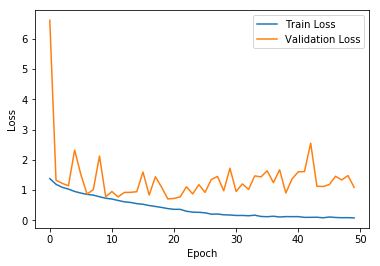

In [0]:
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [0]:
model.save("my_model2.h5")